In [1]:
import numpy as np, matplotlib.pyplot as plt, cv2, tqdm
%matplotlib inline

from importlib import reload

from utils import saveVideo, show, drawShape

import laneFindingPipeline

In [2]:
reload(laneFindingPipeline)

<module 'laneFindingPipeline' from '/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py'>

In [3]:
undistort = laneFindingPipeline.Undistorter()

from glob import glob
undistort.fit(glob('camera_cal/*.jpg'))

A Jupyter Widget

In [4]:
# Load video
videoPrefix = 'project'
fpath = '%s_video.mp4' % videoPrefix
import skvideo.io

reader = skvideo.io.FFmpegReader(fpath)
frames = []
for (i, f) in enumerate(tqdm.tqdm_notebook(
    reader.nextFrame(), 
    total=reader.inputframenum,
)):
    frames.append(f)

A Jupyter Widget

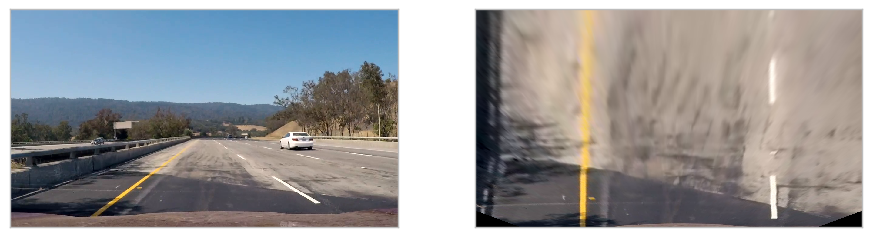

In [5]:
reload(laneFindingPipeline)
perspective = laneFindingPipeline.PerspectiveTransformer()
problemIndices = 298, 10, 550, 200, 612, 1000
frame = frames[problemIndices[2]]
warped = perspective(undistort(frame))

fig, (ax, bx) = plt.subplots(ncols=2)
show(frame, ax=ax);
show(warped, ax=bx);

In [6]:
def circleKernel(ksize):
    kernel = cv2.getGaussianKernel(ksize, 0)
    kernel = (kernel * kernel.T > kernel.min()/3).astype('uint8')
    return kernel
# show(circleKernel(5))

In [7]:
import skvideo.io

videoPrefices = ('project', 'challenge', 'harder_challenge')
allFrames = {}
for videoPrefix in videoPrefices:
    fpath = '%s_video.mp4' % videoPrefix
    reader = skvideo.io.FFmpegReader(fpath)
    frames = []
    for f in tqdm.tqdm_notebook(
        reader.nextFrame(), 
        total=reader.inputframenum,
        desc='load %s' % videoPrefix,
    ):
        frames.append(f)
    allFrames[videoPrefix] = frames

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [408]:
colorFilter = laneFindingPipeline.ColorFilter()
perspective = laneFindingPipeline.PerspectiveTransformer()

def equalizeHist(img):
    img = np.copy(img)
    for i in range(3):
        img[:, :, i] = cv2.equalizeHist(img[:, :, i])
    return img

def morphologicalSmoothing(img, ksize=10):
    # For binary images only.
    # Circular kernel:
    kernel = cv2.getGaussianKernel(ksize, 0)
    kernel * kernel.T > kernel.min() / 3
    # Close holes:
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Despeckle:
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

def uint8scale(vec, lo=0):
    vec = np.copy(vec)
    vec -= vec.min()
    if vec.max() != 0:
        vec /= vec.max()
    vec *= (255 - lo)
    vec += lo
    return vec.astype('uint8')

dilate = lambda image, ksize=5, iterations=1: cv2.dilate(image.astype('uint8'), circleKernel(ksize), iterations=iterations)
erode  = lambda image, ksize=5, iterations=1: cv2.erode( image.astype('uint8'), circleKernel(ksize), iterations=iterations)
opening= lambda image, ksize=5, iterations=1: cv2.morphologyEx(
    image.astype('uint8'), cv2.MORPH_OPEN, np.ones((ksize,ksize)), iterations=iterations
)
blur = lambda image, ksize=5: cv2.GaussianBlur(image, (ksize, ksize), 0)


CPU times: user 2.99 s, sys: 2.12 s, total: 5.11 s
Wall time: 2.5 s


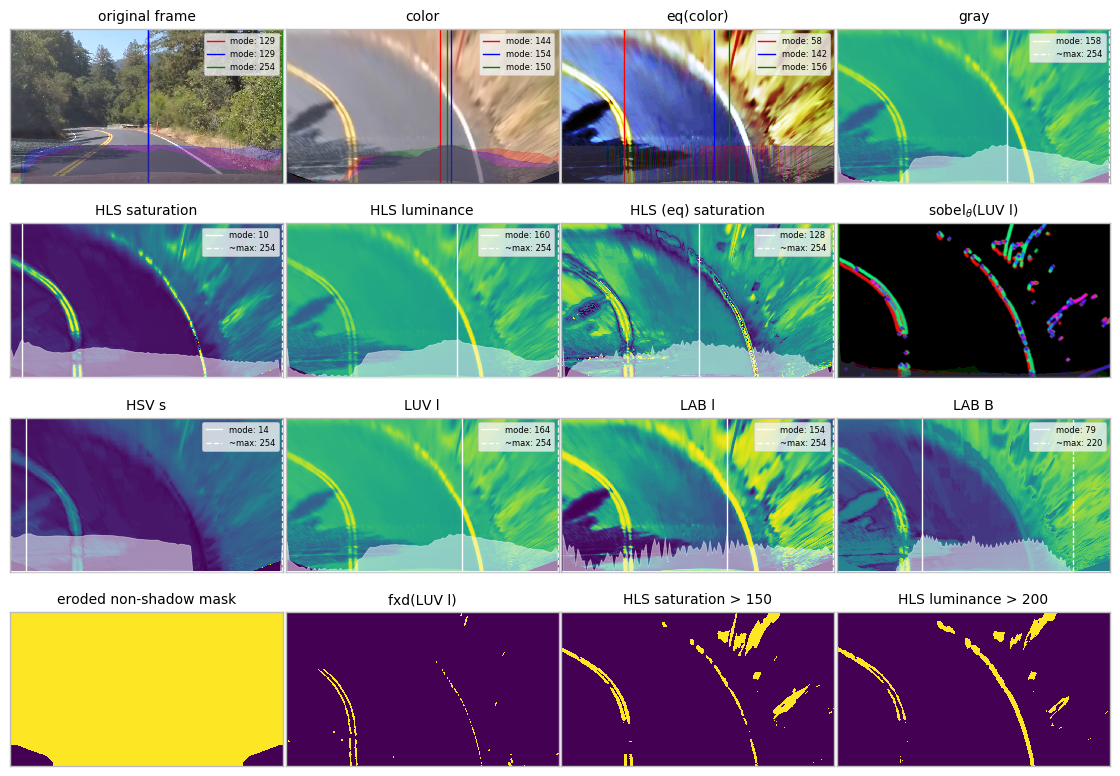

In [23]:
%%time
import utils
def show(img, ax, title=None, doLegend=True):
    ax.imshow(img)
    hi = img.shape[0]
    
    mono = len(img.shape) == 2
    
    if not len(set(img.ravel())) == 2:
        def hist(ichannel, color, heightFraction=.25, histAlpha=.5):
            if not mono:
                histAlpha /= 2
            data = np.copy(img.reshape((img.shape[0], img.shape[1], -1))[:, :, ichannel]).ravel()
            hist, bins = np.histogram(data, bins=128)
            bins = (bins[:-1] + bins[1:]) / 2.
            imax = np.argmax(hist)
            vmax = bins[imax]
            
            brightest = max(bins[hist/max(hist)>1e-4])
            
            hist = np.log10(hist + 1e-10)
            hist -= hist.min()
            hist = hist * img.shape[0] / hist.max() * heightFraction
            bins /= 255
            bins *= img.shape[1]
            ax.fill_between(bins, hi, hi-hist, alpha=histAlpha, color=color, zorder=999)
            ax.axvline(bins[imax], label='mode: %d' % vmax, color=color)
            if mono:
                
                ax.axvline(
                    brightest / 255 * img.shape[1], 
                    label='~max: %d' % brightest, color=color, linestyle='--'
                )
            
        if mono:
            hist(0, 'white')
        else:
            for i in range(3):
                hist(i, ['red', 'blue', 'green'][i])
        if doLegend: ax.legend(fontsize=6, loc='upper right')
    ax.set_xlim(0, img.shape[1])
    ax.set_ylim(hi, -1) 
    
    ax.set_title(title)
    return fig, ax

def plot(fig, axes, frame):
    fx = lambda bw: np.abs(cv2.Sobel(bw, cv2.CV_64F, 1, 0))
    fxd = colorFilter.dilateSobel

    img = perspective(undistort(frame))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    eq = equalizeHist(img)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    hls = cv2.cvtColor(eq, cv2.COLOR_RGB2HLS)
    lq_channel = hls[:, :, 1]
    sq_channel = hls[:, :, 2]
    
    lab = cv2.cvtColor(eq, cv2.COLOR_RGB2LAB)
    labl_channel = lab[:, :, 0]
    labb_channel = lab[:, :, 2]
    
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    luvl_channel = luv[:, :, 0]
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsvs_channel = hsv[:, :, 1]
    hsvh_channel = hsv[:, :, 0]

    # Erode a mask on light areas. This provides a mask
    # to exclude edges due to shadow.
    shadowMask = cv2.erode((gray > 16).astype('uint8'), circleKernel(10), iterations=15)

#     grayFeatures = morphologicalSmoothing(shadowMask & fxd(gray))
#     bfeatures = fxd(b_channel)

    st = 150
    lt = 200
    
    r = 0
    c = 0
    ax = lambda : axes[r][c]
    
    show(frame, ax(), title='original frame'); c+= 1
    show(img, ax(), title='color'); c+= 1
    show(eq, ax(), title='eq(color)'); c+= 1
    show(gray, ax(), title='gray'); c+= 1
    #show(fx(gray), ax=axes[0][3], title='sobelx(gray)')
        
    c=0; r+= 1
    
    #show(h_channel, ax(), title='HLS hue'); c+= 1
    show(s_channel, ax(), title='HLS saturation'); c+= 1
    show(l_channel, ax(), title='HLS luminance'); c+= 1
    show(sq_channel, ax(), title='HLS (eq) saturation'); c+= 1
    #show(hsvh_channel, ax(), title='HSV h'); c+= 1
    #show(lq_channel, ax(), title='HLS (eq) luminance'); c+= 1
    #show(sobeltheta, ax(), title=r'sobel$_\theta$(LUV l)'); c+= 1
    #show(sobelx, ax(), title=r'sobel$_x$(LUV l)'); c+= 1
    #show(sobely, ax(), title=r'sobel$_y$(LUV l)'); c+= 1
    
    toSobel = (s_channel>st).astype('uint8')*255
    sobelx = dilate(cv2.Sobel(toSobel, cv2.CV_64F, 1, 0), iterations=4)
    sobely = dilate(cv2.Sobel(toSobel, cv2.CV_64F, 0, 1), iterations=4)
    sobelmag = np.log10(np.sqrt(sobelx ** 2 + sobely ** 2) + 1)
    sobeltheta = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    one = np.ones_like(sobeltheta, 'uint8')*240
    hue = uint8scale(sobeltheta)
    mag = uint8scale(sobelmag, lo=0)
    sobelhsv = np.dstack((hue, one, mag))
    show(
        cv2.GaussianBlur(
            cv2.cvtColor(sobelhsv, cv2.COLOR_HSV2RGB),
            (15, 15), 0
        ), 
        ax(), title=r'sobel$_\theta$(LUV l)', doLegend=False
    ); c+= 1
    
    c=0; r+= 1
    
    show(hsvs_channel, ax(), title='HSV s'); c+= 1
    show(luvl_channel, ax(), title='LUV l'); c+= 1
    show(labl_channel, ax(), title='LAB l'); c+= 1
    show(labb_channel, ax(), title='LAB B'); c+= 1
    
    c=0; r+= 1

    
    
    show(shadowMask, ax(), title='eroded non-shadow mask'); c+= 1
    #show(bfeatures, ax=axes[1][1], title='b features')
    #show(grayFeatures, ax=axes[1][2], title='gray features')
    #show(fxd(gray), ax=axes[1][3], title='sobelxDilate(gray)')
    show(fxd(luvl_channel), ax(), title='fxd(LUV l)'); c+= 1
    show(s_channel>st, ax(), title='HLS saturation > %s' % st); c+= 1
    show(l_channel>lt, ax(), title='HLS luminance > %s' % lt); c+= 1
    
    for r in axes:
        for ax in r:
            ax.title.set_fontsize(10)
            ax.set_xticks([])
            ax.set_yticks([])

    fig.subplots_adjust(bottom=0, left=0, right=1, top=.95, wspace=0.01, hspace=.1)

fa = lambda : plt.subplots(nrows=4, ncols=4)
fig, axes = fa()
plot(fig, axes, allFrames['harder_challenge'][42])
fig.savefig('doc/grid.png')

In [243]:
import utils
reload(utils)
reload(laneFindingPipeline)

<module 'laneFindingPipeline' from '/home/tsbertalan/Dropbox/Projects/Lane Lines/laneFindingPipeline.py'>

In [24]:
maxframes = 320000
overallBar = tqdm.tqdm_notebook(
    total=sum([min(len(fr), maxframes) for fr in allFrames.values()]), 
    unit='frame', desc='%d videos' % len(allFrames)
)

for videoPrefix in videoPrefices:
    frames = allFrames[videoPrefix][:maxframes]
    
    def yieldPlots():

        fig, axes = fa()

        for frame in frames:
            overallBar.update()

            plot(fig, axes, frame)

            yield utils.fig2img(fig)

            for r in axes:
                for ax in r:
                    ax.cla()
                    
        fig.clf()

    utils.saveVideo(
        yieldPlots(), 'filterOptions-%s.mp4' % videoPrefix, 
        total=len(frames), desc=videoPrefix,
    )

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

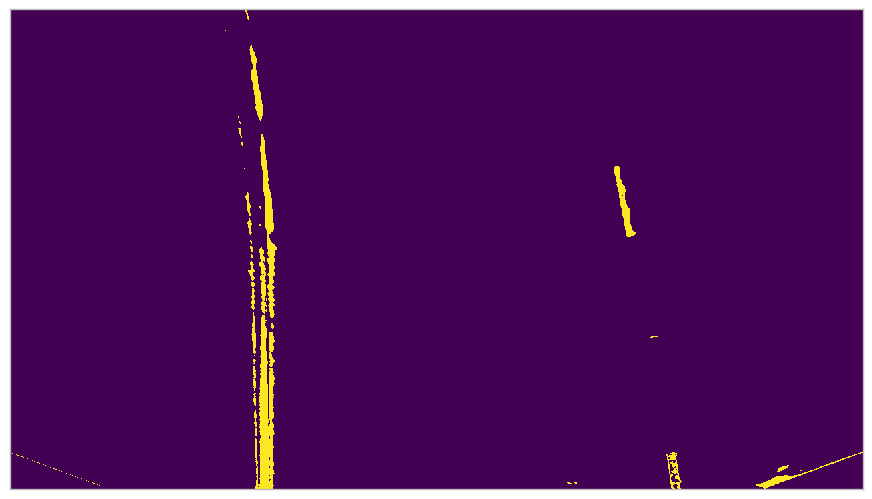

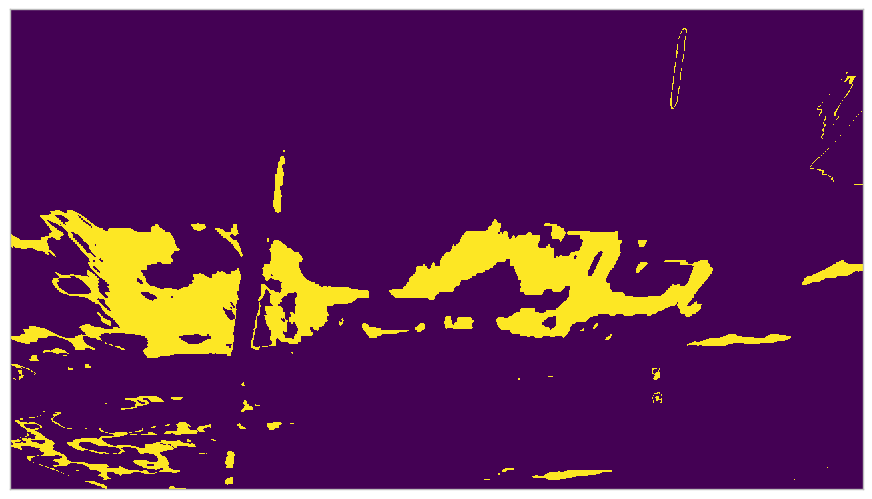

In [390]:
easyFrame = allFrames['project'][68]
hardFrame = allFrames['project'][1041]
def get_s(frame, eq=True):
    img = perspective(undistort(frame))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    if eq:
        img = equalizeHist(img)

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:, :, 2]
method = 'HL[S](eq)'
#utils.show(hardFrame);
utils.show(get_s(easyFrame) > 250);
utils.show(get_s(hardFrame) > 254);

In [391]:
# fig, ax = plt.subplots()
# framesMax = 2000
# counts = []
# def yieldFrames():
#     for frame in allFrames['project'][:framesMax]:
#         thr = get_s(frame) > 150
#         ct = thr.sum()
#         counts.append(ct)
#         utils.show(thr, ax=ax, title='%d pixels' % ct)
#         yield utils.fig2img(fig)
#         ax.cla()
# vid = utils.saveVideo(yieldFrames(), 'thresholdCounts.mp4', total=framesMax)
# fig.clf()
# vid

In [392]:
# fig, ax = plt.subplots()
# counts = np.array(counts)
# ax.hist(counts[(counts < 20000) & (counts > 5000)], bins=32)
# ax.set_xlabel('number of pixels over threshold')
# ax.set_ylabel('number of frames');

In [416]:
class CountSeekingThreshold:
    
    def __init__(self, initialThreshold=150):
        self.threshold = initialThreshold
        self.iterationCounts = []
        
    def __call__(self, channel, goalCount=10000, countTol=200):
        
        def getCount(threshold):
            mask = channel > np.ceil(threshold)
            return mask, mask.sum()
        
        threshold = self.threshold
        
        under = 0
        over = 255
        getThreshold = lambda : (over - under) / 2 + under
        niter = 0
        while True:
            mask, count = getCount(threshold)
            if (
                abs(count - goalCount) < countTol
                or over - under <= 1
            ):
                break

            if count > goalCount:
                # Too many pixels got in; threshold needs to be higher.
                under = threshold
                threshold = getThreshold()
            else: # count < goalCout
                if threshold > 254 and getCount(254)[1] > goalCount:
                    # In the special case that opening any at all is too bright, die early.
                    threshold = 255
                    mask = np.zeros_like(channel, 'bool')
                    break
                over = threshold
                threshold = getThreshold()
            niter += 1
                
        out =  max(min(int(np.ceil(threshold)), 255), 0)
        self.threshold = out
        self.iterationCounts.append(niter)
        return mask, out
                    
    
countSeekingThreshold = CountSeekingThreshold()
for frame in easyFrame, hardFrame:
    mask, thresh = countSeekingThreshold(get_s(frame))
    print(thresh, '-->', mask.sum())

250 --> 12484
255 --> 0


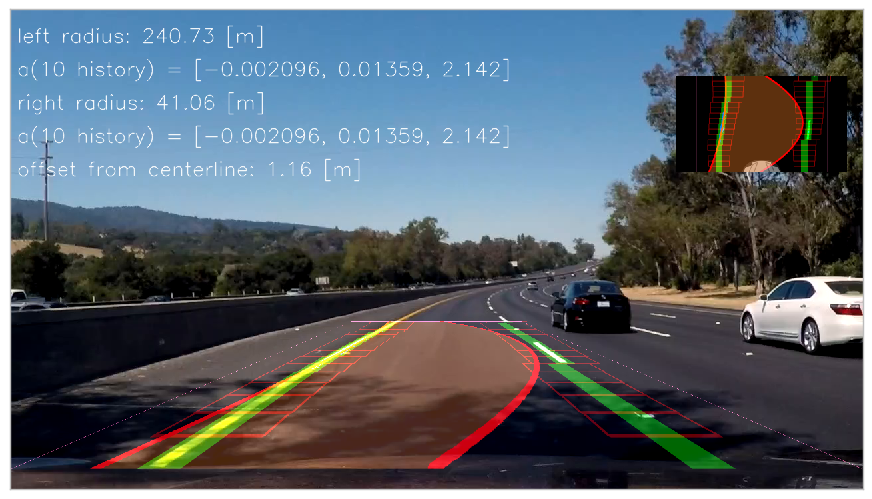

In [395]:
utils.show(laneFinder.draw(allFrames['project'][1050]));

In [417]:
reload(laneFindingPipeline)

try:
    'project' in vids
except NameError:
    vids = {}
    
colorFilter = laneFindingPipeline.ColorFilter()

for videoPrefix in ('project', 'challenge', 'harder_challenge',):
# for videoPrefix in ('harder_challenge',):
    
    fig, rows = plt.subplots(nrows=5, ncols=5)
    axes = []
    for row in rows: axes.extend(row)
        
    frames = allFrames[videoPrefix]
    lo, hi = dict(
        #project=(980, 1050),
        project=(980, 1000),
        #challenge=(102, 164),
        challenge=(133, 164),
        #harder_challenge=(100, 200),
        harder_challenge=(169, 200),
    )[videoPrefix]
    frameIndices = list(range(len(frames)))[lo:hi]
    
    laneFinder = laneFindingPipeline.LaneFinder(undistort)

    def yieldFrames(blurK=71):
        for i in frameIndices:
            iaxes = iter(axes)
            color = 'black'
            def show(item, title=None, kind='permissive'):
                if len(set(item.ravel())) == 2 and kind == 'permissive':
                    kind = 'mask'
                import matplotlib.cm
                from matplotlib.colors import LinearSegmentedColormap
                kind = dict(
                    permissive='viridis',
                    restrictive='plasma',
                    mask='binary_r',
                    pton=LinearSegmentedColormap.from_list(
                        'Princeton', [(0,0,0), (232/255, 119/255, 34/255)], N=2
                    )
                ).get(kind, kind)
                cmap = matplotlib.cm.get_cmap(kind)
                ax = iaxes.__next__()
                ax.imshow(item, cmap=cmap)
                ax.set_xticks([]); ax.set_yticks([])
                if title is not None:
                    ax.set_title(title, fontsize=8, color=color)
                    
            def sobelclip(channel):
                # Adaptive thresholding of color.
                tmask, thresh = countSeekingThreshold(channel)

                # Dilated masks of the threshold.
                narrow = dilate(tmask, ksize=10, iterations=5)
                wide = dilate(narrow, ksize=10, iterations=5)
                
                # Restricted Sobel-X
                toSobel = np.copy(channel)
                toSobel[np.logical_not(wide)] = 0
                
                sobel = colorFilter.dilateSobel(toSobel)
                clippedSobel = sobel & narrow
                
                return tmask, thresh, narrow, wide, toSobel, sobel, clippedSobel
            
            # Do basic transforms.
            frame = frames[i]
            warped = perspective(undistort(frame))
            blurred = cv2.GaussianBlur(warped, (5, 5), 0)
            show(frame, 'frame %d' % i)
            show(warped)
            show(blurred, 'blurred')
            
            # Get channels.
            gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
            show(gray, 'gray', kind='Greys_r')
            hls = cv2.cvtColor(blurred, cv2.COLOR_RGB2HLS)
            eq = equalizeHist(blurred)
            show(eq, 'equalized histogram')
            l_channel = hls[:, :, 1]
            s_channel = hls[:, :, 2]
            hls = cv2.cvtColor(eq, cv2.COLOR_RGB2HLS)
            #leq_channel = hls[:, :, 1]
            
            bseq_channel = blur(hls[:, :, 2], blurK)
            lab = cv2.cvtColor(eq, cv2.COLOR_RGB2LAB)
            labaeq_channel = lab[:, :, 1]
            blabbeq_channel = blur(lab[:, :, 2], blurK)
            show(s_channel, r's_channel')
            show(l_channel, r'l_channel')
            show(bseq_channel, 'blur(seq_channel, %d)' % blurK)
            #show(leq_channel, 'leq_channel')
            #show(labaeq_channel, 'labaeq_channel')
            show(blabbeq_channel, 'blur(labbeq_channel, %d)' % blurK)
            
            show(countSeekingThreshold(bseq_channel)[0], 'blur(seq_channel, %d)' % blurK)
            
            color = 'green'
            tmask, thresh, narrow, wide, toSobel, sobel, clippedSobel = sobelclip(s_channel)
            show(tmask, r's thresh (>%d, %d px) $\longmapsto$' % (thresh, tmask.sum()))
            show(narrow, 'narrow dilated s thresh $\longmapsto$')
            show(wide, 'wide dilated s thresh $\longmapsto$')
            show(toSobel, 'wide-clipped s_channel $\longmapsto$')
            show(sobel, 'sobel = fxd(wide-clipped s_channel) $\longmapsto$')
            show(clippedSobel, 'clippedSobel = narrow-clipped sobel')
            
            S = clippedSobel
            
#             # Erode a mask on light areas. This provides a mask
#             # to exclude edges due to shadow.
#             shadowMask = erode(gray > 16, ksize=10, iterations=15)
#             show(shadowMask, 'grayscale shadow mask')

            

            # Adaptive thresholding of brighter color.
            color = 'red'
            labbeqmask, labbeqthresh = countSeekingThreshold(blabbeq_channel)
            labbeqmask = dilate(labbeqmask)
            S = clippedSobel & labbeqmask# & shadowMask
            show(labbeqmask, r'dilate(blur(labbeq) thresh (>%d, %d px)) $\longmapsto$' % (labbeqthresh, labbeqmask.sum()))
            show(S, 'S = clippedSobel & labbeqmask', kind='restrictive')


#             # Look for colorful lines.
#             s_binary = s_channel > 170
#             s_binary = s_binary & shadowMask
#             show(s_binary, 'simple s threshold & shadow mask', kind='restrictive')

            color = 'blue'
            _, _, _, _, toSobelL, _, clippedSobelL = sobelclip(l_channel)
            show(toSobelL, 'wide-clipped l_channel $\longmapsto\ldots\longmapsto$')

            # Look for bright lines
            L = clippedSobelL# & shadowMask
            L = dilate(L)
            show(L, 'L = dilate(fxd(clipped sobel l))', kind='restrictive')
            
            # Finally combine strands with OR.
            Y = S | L
            color = 'black'
            show(Y, 'Y = S | L', kind='pton')
            
            laneFinder.update(Y)
            drawn = laneFinder.draw(frame, call=False, showCentroids=False, showCurves=False, showTrapezoid=False)
            show(drawn, 'composite')
            
            for ax in axes:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
            fig.subplots_adjust(bottom=0, left=0, right=1, top=.95, wspace=.01, hspace=.18)
            
            
                      
            yield utils.fig2img(fig)
            for ax in axes: ax.cla()
    vid = utils.saveVideo(
        yieldFrames(), 'thresholdSearch-%s.mp4' % videoPrefix, 
        total=len(frameIndices), desc=videoPrefix)
    fig.clf()
    vids[videoPrefix] = vid
    

A Jupyter Widget

A Jupyter Widget

Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)

A Jupyter Widget

Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)
Some lane markings failed inspection!
Some lane markings failed inspection!
(recursion #1)


A rule seems to be emerging--build the filter in layers, with early layers being permissive and later ones being restrictive. A network of layers, you might say. With decision nodes in each layer--almost like "neurons" of some sort.

In [374]:
# import time
# time.sleep(4)

In [369]:
# vids['project']

In [370]:
# vids['challenge']

In [373]:
# vids['harder_challenge']

In [ ]:
colorFilter = laneFindingPipeline.ColorFilter()
for videoPrefix in ('project', 'challenge', 'harder_challenge'):
    fig, ax = plt.subplots()
    frames = allFrames[videoPrefix]
    frameIndices = list(range(len(frames)))[:100]
    def yieldFrames():
        for i in frameIndices:
            frame = frames[i]
            img = perspective(undistort(frame))
            img = cv2.GaussianBlur(img, (5, 5), 0)
            #eq = equalizeHist(img)
            
            luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            luvl_channel = luv[:, :, 0]
            lab = cv2.cvtColor(eq, cv2.COLOR_RGB2LAB)
            labl_channel = lab[:, :, 0]
            labb_channel = lab[:, :, 2]
            
            mask = colorFilter.dilateSobel(labb_channel)
            ct = mask.sum()
            utils.show(mask, ax=ax, title=method+'\n'+r'%s frame %d: < %.4g $\rightarrow$ %d pts' % (videoPrefix, i, thresh, ct))
            #ax.title.set_fontsize(10)
            yield utils.fig2img(fig)
            ax.cla()
    vid = utils.saveVideo(
        yieldFrames(), 'thresholdSearch-%s.mp4' % videoPrefix, 
        total=len(frameIndices), desc=videoPrefix)
    fig.clf()
    vids[videoPrefix] = vid

In [ ]:
fig, ax = plt.subplots()
ax.hist(countSeekingThreshold.iterationCounts);

(<matplotlib.figure.Figure at 0x7fca53b23128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca423324a8>)

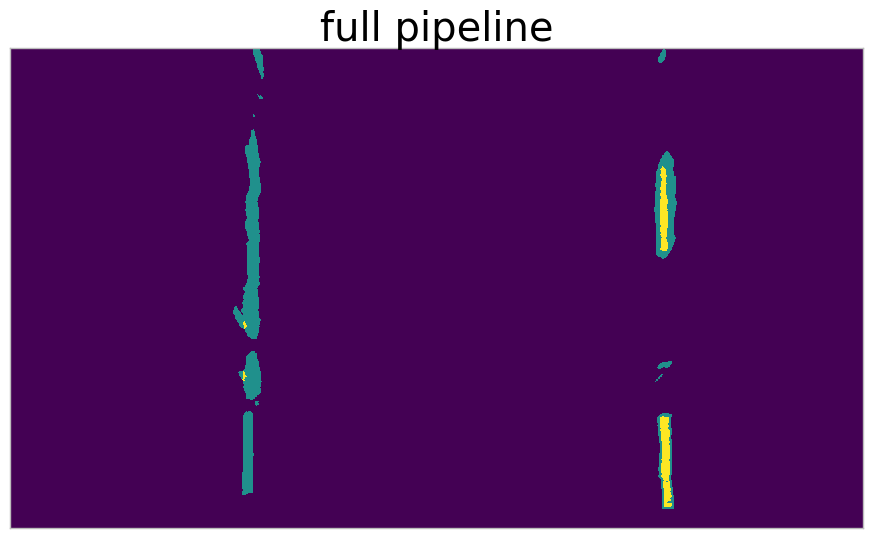

In [26]:
laneFinder = laneFindingPipeline.LaneFinder(undistort)
utils.show(laneFinder.preprocess(frame), title='full pipeline')

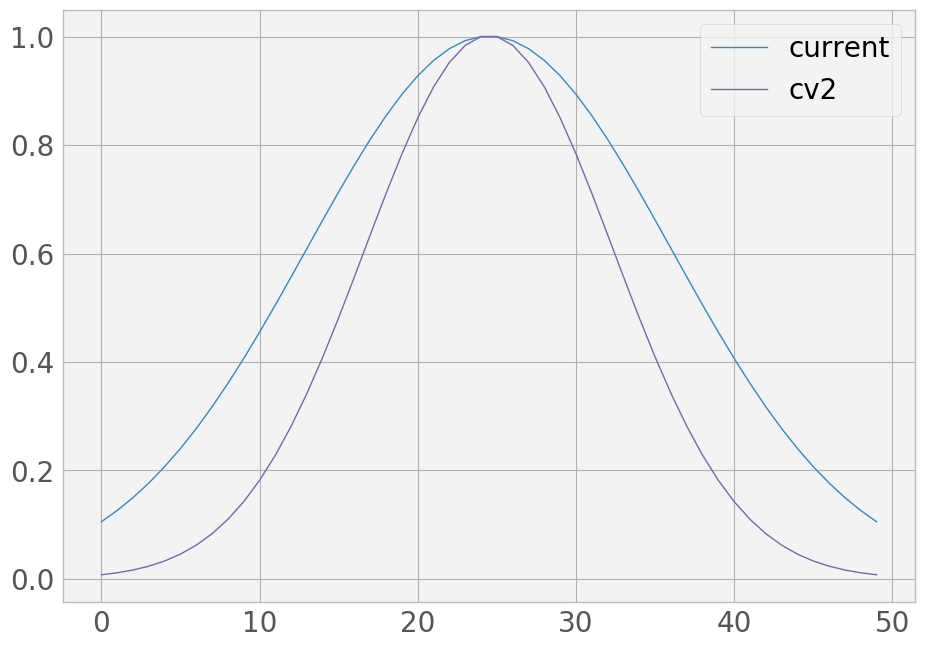

In [27]:
window_width = 50
radius = laneFinder.markingFinder.gaussianRadius
k = np.exp(-np.linspace(-radius, radius, window_width)**2)
plt.plot(k/k.max(), label='current')
k = cv2.getGaussianKernel(window_width, 0)
plt.plot(k/k.max(), label='cv2')
plt.legend()

How much of the lane's width does a typical 80-inch car take up?

In [28]:
laneOccupancyFraction = 2.032 / 3.7
laneOccupancyFraction

0.5491891891891891

(<matplotlib.figure.Figure at 0x7fca30da9c88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fca3df2b0f0>)

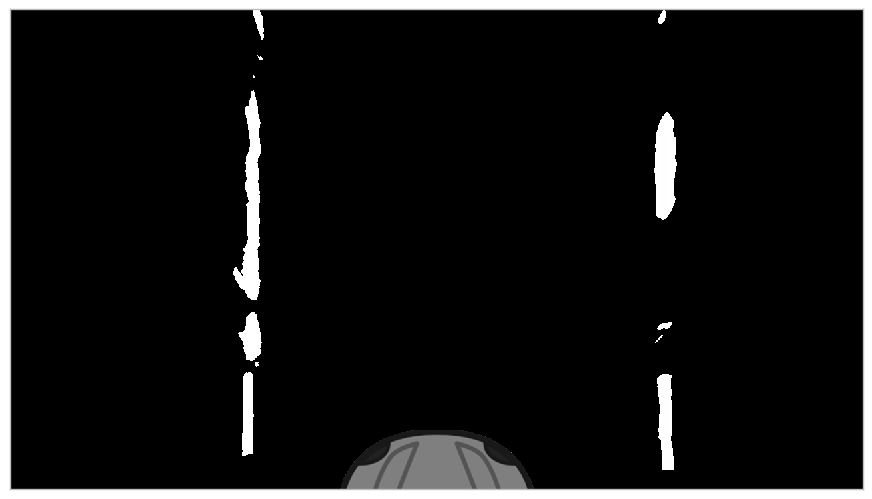

In [29]:
car = cv2.imread('carOverlay.png')
pp = laneFinder.preprocess(frame) * 255
utils.show(cv2.addWeighted(car, 1.0, cv2.merge((pp, pp, pp)), 1.0, 0))

In [30]:
# sobelx = np.abs(cv2.Sobel(s_channel, cv2.CV_64F, 1, 0))
# # Show the effect of the positive dilation.
# self = colorFilter
# s_thresh = self.s_thresh
# sx_thresh = self.sx_thresh
# dilate_kernel = self.dilate_kernel
# dilationIterations = self.dilationIterations
# mask_pos = (sobelx > sx_thresh).astype(np.float32)
# mid = dilate_kernel[1] // 2

# kernel = np.ones(dilate_kernel, np.uint8)
# kernel[:, mid:] = 0
# dmask_pos = cv2.dilate(mask_pos, kernel, iterations=dilationIterations) > 0.

# show(dmask_pos)

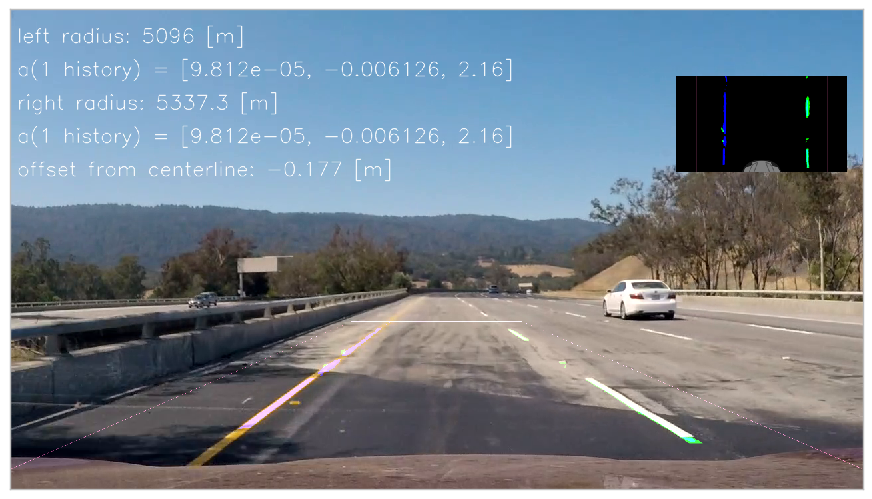

In [31]:
reload(laneFindingPipeline)
laneFinder = laneFindingPipeline.LaneFinder(undistort)
laneFinder.colorFilter.dilate_kernel = colorFilter.dilate_kernel
utils.show(laneFinder.draw(frame, showTrapezoid=True, showLane=False, showCentroids=False, insetBEV=True, showCurves=False));

# fig, ax = plt.subplots(figsize=(9, 16))
# laneFinder.show(frame, axes=[ax]);

# Regularization

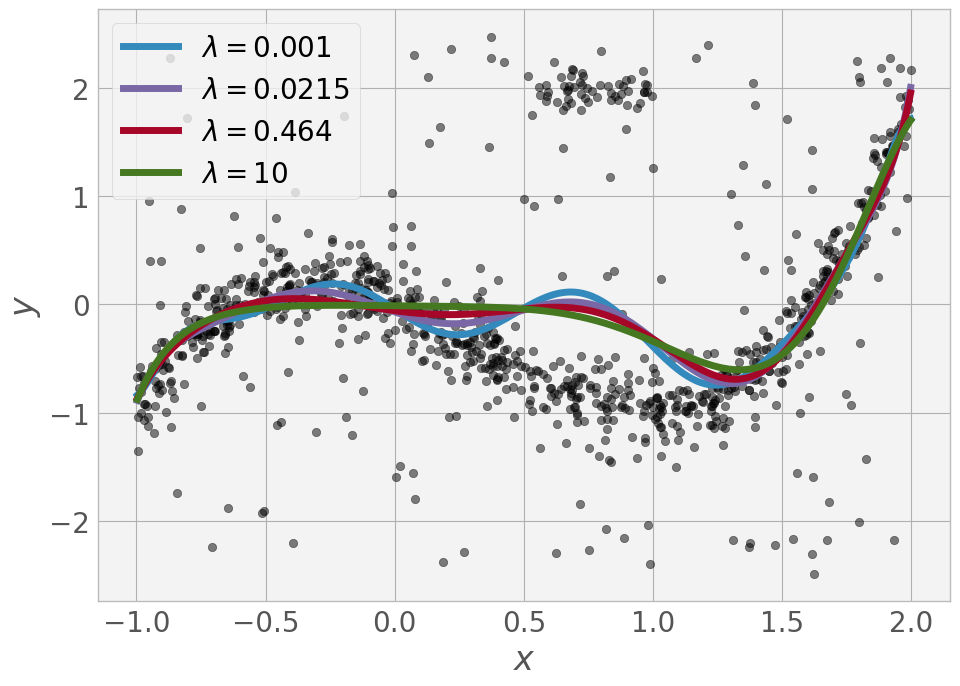

In [365]:
X = np.random.uniform(low=-1, high=2, size=(1000,))
X.sort()
Y1 = X ** 3 - X ** 2 - X + np.random.normal(size=X.shape, scale=.2)
Y = Y1

Y2 = np.random.uniform(low=-2.5, high=2.5, size=Y1.shape)
pnoise = .2
Y = [np.random.choice([y, y2], p=[1-pnoise, pnoise]) for (y, y2) in zip(Y, Y2)]

Y2 = np.copy(Y1)
for i in range(len(Y2)):
    if .5 < X[i] < 1:
        Y2[i] = np.random.normal(loc=2, scale=.1)
pnoise = .3
Y = [np.random.choice([y, y2], p=[1-pnoise, pnoise]) for (y, y2) in zip(Y, Y2)]

def regularizedPolyfit(x, y, deg, lamb=0):
    if lamb == 0:
        return np.polyfit(x, y, deg)
    else:
        A = np.stack([x**k for k in range(deg)[::-1]]).T
        n_col = A.shape[1]
        fit, residuals, rank, s = np.linalg.lstsq(
            A.T.dot(A) + lamb * np.identity(n_col), 
            A.T.dot(y)
        )
        return fit

fig, ax = plt.subplots()
ax.scatter(X, Y, color='black', alpha=.5)

for lamb in np.logspace(-3, 1, 4):
    fit = regularizedPolyfit(X, Y, lamb=lamb)
    ax.plot(X, np.polyval(fit, X), label='$\lambda=%.3g$' % lamb, linewidth=5)
ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');